In [1]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter

from qiskit.quantum_info.operators import Operator, Pauli
from qiskit.extensions import RXGate, RZGate
from qiskit.circuit import QuantumRegister,ClassicalRegister
from qiskit import  execute, BasicAer
import qiskit.quantum_info as qi
import scipy.optimize 
import random
import matplotlib.pyplot as plt
import pickle
import os 
from sklearn.model_selection import train_test_split
import time
from qiskit_machine_learning.algorithms.classifiers import VQC
from qiskit.circuit.library import RealAmplitudes
from sklearn.utils import shuffle

from qiskit.primitives import Sampler
from qiskit.circuit.library import ZZFeatureMap,ZFeatureMap
from qiskit_algorithms.optimizers import COBYLA
from IPython.display import clear_output
from qiskit import  execute, BasicAer

from qiskit.circuit import ParameterVector

from qiskit.primitives import Sampler
from qiskit_machine_learning.neural_networks import SamplerQNN
from qiskit.circuit.library import ZZFeatureMap
from qiskit_algorithms.utils import algorithm_globals


In [2]:
name='_smear0.1_MaxTran10.0_shuffle1_scaling1'
# name='_smear0.1_MaxTran10_shuffle0'
resultsName="results"+name


folderDir="/Users/lizhelun/Desktop/QC/VQC-Permutable-Lorentz-symmetry/"
dataDir="/Users/lizhelun/Desktop/QC/VQC-Permutable-Lorentz-symmetry/Images"


#nShots=2**13
maxIteration=500
maxEvents=100
nLayer_realAmplitude=6
maxEvents=100
training_results={}



with open(dataDir+"/label"+name+".pk", "rb") as fp:   #Pickling
    label=pickle.load(fp)
    
with open(dataDir+"/images"+name+".pk", "rb") as fp:   #Pickling
    images=pickle.load(fp)
    
X=images.reshape(images.shape[0],images.shape[1]*images.shape[2])
y=label







y[y==0]=-1







X,y=shuffle(X,y,random_state=1000)
train_ratio=0.6
X_train, X_valTest, y_train, y_valTest = train_test_split(X.copy(), y.copy(), train_size=train_ratio, random_state=100)
X_val, X_test, y_val, y_test = train_test_split(X_valTest, y_valTest, test_size=0.5, random_state=200)
#Normalizing everythings:
X_train=X_train/X_train.max()
X_val=X_val/X_val.max()
X_test=X_test/X_test.max()

sampler = Sampler()
print("number of training: ",y_train.shape[0])
print("number of validation: ",y_val.shape[0])
print("number of test: ",y_test.shape[0])

number of training:  1200
number of validation:  400
number of test:  400


In [3]:
def dataAugmentation(data):
    #centering
    meanValues=data.mean(axis=1)
    print(data.shape)
    print(meanValues.shape)
    data=data-meanValues[:,None,:]
    
    #scaling
    norm=np.linalg.norm(data,axis=2)
    scale=norm.max(axis=1)
    data=data/scale[:,None,None]
    
    return data

def Dot(data):
    output=[]
    

 
    for i in range(data.shape[0]):
        event=[]
        #first record dot product with itself:
        for j in range(data.shape[1]):
            event.append((data[i][j]*data[i][j]).sum())
            
        for j in range(data.shape[1]):
            for k in np.arange(j+1,data.shape[1]):
                event.append((data[i][j]*data[i][k]).sum())
        output.append(np.array(event))
    
    output=np.array(output)
    return output
    

In [4]:
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

def callback_graph(weights, obj_func_eval):
    print(len(objective_func_vals))
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [5]:

X_augDot=Dot(dataAugmentation(images))
y_augDot=label

X_augDot,y_augDot=shuffle(X_augDot,y_augDot,random_state=1000)
train_ratio=0.6
X_train_augDot, X_valTest_augDot, y_train_augDot, y_valTest_augDot = train_test_split(X_augDot.copy(), y_augDot.copy(), train_size=train_ratio, random_state=100)
X_val_augDot, X_test_augDot, y_val_augDot, y_test_augDot = train_test_split(X_valTest_augDot, y_valTest_augDot, test_size=0.5, random_state=200)
#Normalizing everythings:
X_train_augDot=X_train_augDot/X_train_augDot.max()
X_val_augDot=X_val_augDot/X_val_augDot.max()
X_test_augDot=X_test_augDot/X_test_augDot.max()

num_qubits=X_augDot.shape[1]



(2000, 4, 2)
(2000, 2)


In [6]:
num_layers=10
n_inputParams=num_qubits
n_params=num_layers*4
N_particles=4
num_qubits=int((N_particles+1)*N_particles/2)

In [7]:
n_params

40

In [8]:
qr = QuantumRegister(num_qubits)
qc = QuantumCircuit(qr)
feature_map = ZFeatureMap(feature_dimension=num_qubits,reps=1,parameter_prefix="inputs")
ansatz=RealAmplitudes(num_qubits, reps=nLayer_realAmplitude)

weights = ParameterVector("weight", n_params)
print(f"weight parameters: {[str(item) for item in weights.params]}")

inputParams_index=0
params_index=0


qc.compose(feature_map, inplace=True) 
qc.compose(ansatz,inplace=True)    


weight parameters: ['weight[0]', 'weight[1]', 'weight[2]', 'weight[3]', 'weight[4]', 'weight[5]', 'weight[6]', 'weight[7]', 'weight[8]', 'weight[9]', 'weight[10]', 'weight[11]', 'weight[12]', 'weight[13]', 'weight[14]', 'weight[15]', 'weight[16]', 'weight[17]', 'weight[18]', 'weight[19]', 'weight[20]', 'weight[21]', 'weight[22]', 'weight[23]', 'weight[24]', 'weight[25]', 'weight[26]', 'weight[27]', 'weight[28]', 'weight[29]', 'weight[30]', 'weight[31]', 'weight[32]', 'weight[33]', 'weight[34]', 'weight[35]', 'weight[36]', 'weight[37]', 'weight[38]', 'weight[39]']


/Users/lizhelun/miniforge3/envs/qc/lib/python3.10/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


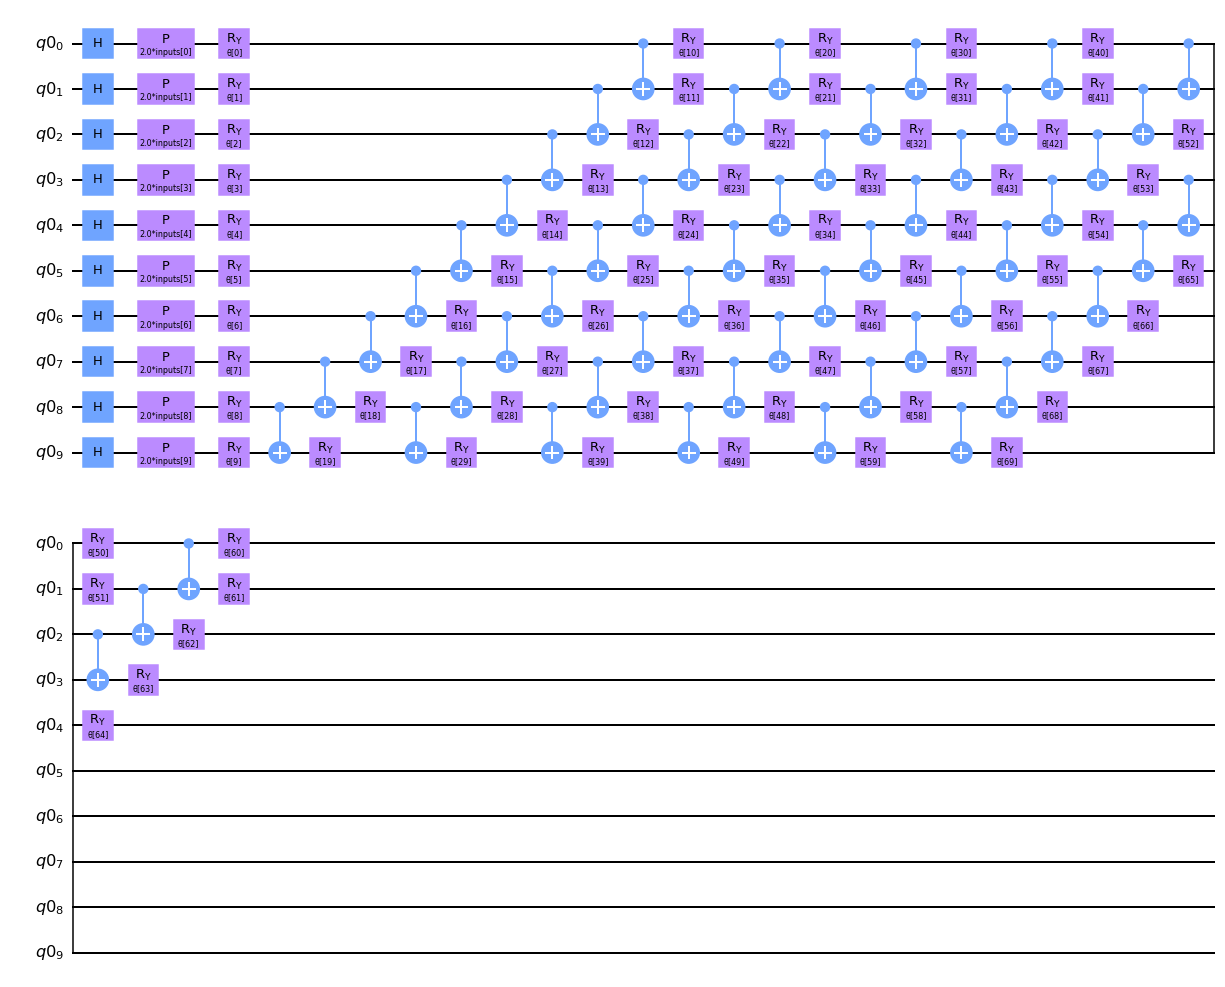

In [9]:
qc.decompose().draw('mpl')

In [10]:
zeroState = '0'
for i in range(num_qubits-1):
    zeroState+='0'
def countZero(x):
    return f"{bin(x)}".count("0")%(num_qubits+1)

In [11]:
from qiskit.quantum_info import SparsePauliOp

observable1 = SparsePauliOp.from_list([("Z" * num_qubits, 1)])

In [12]:
from qiskit_machine_learning.neural_networks import EstimatorQNN

In [13]:
estimator_qnn = EstimatorQNN(
    circuit=qc, observables=observable1, input_params=feature_map.parameters, weight_params=ansatz.parameters
)


In [14]:
index=10
shuffled=shuffle(images[index],random_state=np.random.randint(100))[None,:]
dot1=Dot(images[index:index+1])
dot2=Dot(shuffled)

estimator_qnn_weights = algorithm_globals.random.random(estimator_qnn.num_weights)
out1=estimator_qnn.forward(dot1, estimator_qnn_weights)
out2=estimator_qnn.forward(dot2, estimator_qnn_weights)
print(out1)
print(out2)

[[-0.03593537]]
[[0.04241455]]


In [15]:

from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor, VQR

In [16]:
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

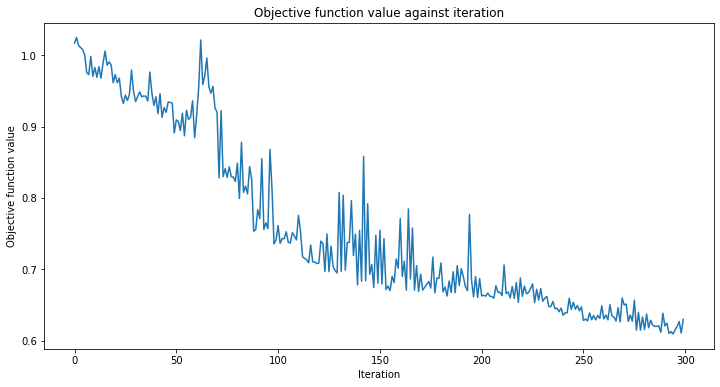

0.67

In [17]:
estimator_classifier = NeuralNetworkClassifier(
    estimator_qnn, optimizer=COBYLA(maxiter=300), callback=callback_graph
)


objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit classifier to data
estimator_classifier.fit(X_train_augDot[0:maxEvents], y_train_augDot[0:maxEvents])

# return to default figsize
# plt.rcParams["figure.figxsize"] = (6, 4)

# score classifier
estimator_classifier.score(X_test_augDot[0:maxEvents], y_test_augDot[0:maxEvents])

In [18]:
estimator_classifier.score(X_train_augDot[0:maxEvents], y_train_augDot[0:maxEvents])

0.84

In [19]:
estimator_classifier.score(X_test_augDot[0:maxEvents], y_test_augDot[0:maxEvents])

0.67

In [20]:
num_layers=20
n_inputParams=num_qubits
n_params=num_layers*4
N_particles=4
num_qubits=int((N_particles+1)*N_particles/2)

In [21]:
qr = QuantumRegister(num_qubits)
qc = QuantumCircuit(qr)
feature_map = ZFeatureMap(feature_dimension=num_qubits,reps=1,parameter_prefix="inputs")


weights = ParameterVector("weight", n_params)
print(f"weight parameters: {[str(item) for item in weights.params]}")

inputParams_index=0
params_index=0


qc.compose(feature_map, inplace=True) 
   
for layer in range(num_layers):
    
        for i in range(N_particles):
            qc.ry(weights[params_index],i)
            
        params_index += 1 
        
        for i in range(N_particles):
            for k in np.arange(i,N_particles,1):
                if i!=k:
                    qc.rzz(weights[params_index],i,k)
            
            
        params_index += 1
        for j in np.arange(N_particles,num_qubits,1):
            qc.ry(weights[params_index],j)
        params_index += 1
        
        for i in np.arange(N_particles,num_qubits,1):
            for k in np.arange(i,num_qubits,1):
                if i!=k:
                    qc.rzz(weights[params_index],i,k)
                    
        params_index += 1
            
        
        qc.barrier()

weight parameters: ['weight[0]', 'weight[1]', 'weight[2]', 'weight[3]', 'weight[4]', 'weight[5]', 'weight[6]', 'weight[7]', 'weight[8]', 'weight[9]', 'weight[10]', 'weight[11]', 'weight[12]', 'weight[13]', 'weight[14]', 'weight[15]', 'weight[16]', 'weight[17]', 'weight[18]', 'weight[19]', 'weight[20]', 'weight[21]', 'weight[22]', 'weight[23]', 'weight[24]', 'weight[25]', 'weight[26]', 'weight[27]', 'weight[28]', 'weight[29]', 'weight[30]', 'weight[31]', 'weight[32]', 'weight[33]', 'weight[34]', 'weight[35]', 'weight[36]', 'weight[37]', 'weight[38]', 'weight[39]', 'weight[40]', 'weight[41]', 'weight[42]', 'weight[43]', 'weight[44]', 'weight[45]', 'weight[46]', 'weight[47]', 'weight[48]', 'weight[49]', 'weight[50]', 'weight[51]', 'weight[52]', 'weight[53]', 'weight[54]', 'weight[55]', 'weight[56]', 'weight[57]', 'weight[58]', 'weight[59]', 'weight[60]', 'weight[61]', 'weight[62]', 'weight[63]', 'weight[64]', 'weight[65]', 'weight[66]', 'weight[67]', 'weight[68]', 'weight[69]', 'weight[70

In [22]:
estimator_qnn = EstimatorQNN(
    circuit=qc, observables=observable1, input_params=feature_map.parameters, weight_params=weights
)

In [23]:
index=10
shuffled=shuffle(images[index],random_state=np.random.randint(100))[None,:]
dot1=Dot(images[index:index+1])
dot2=Dot(shuffled)

estimator_qnn_weights = algorithm_globals.random.random(estimator_qnn.num_weights)
out1=estimator_qnn.forward(dot1, estimator_qnn_weights)
out2=estimator_qnn.forward(dot2, estimator_qnn_weights)
print(out1)
print(out2)

[[-0.0026001]]
[[-0.0026001]]


In [24]:
estimator_classifier = NeuralNetworkClassifier(
    estimator_qnn, optimizer=COBYLA(maxiter=300), callback=callback_graph
)

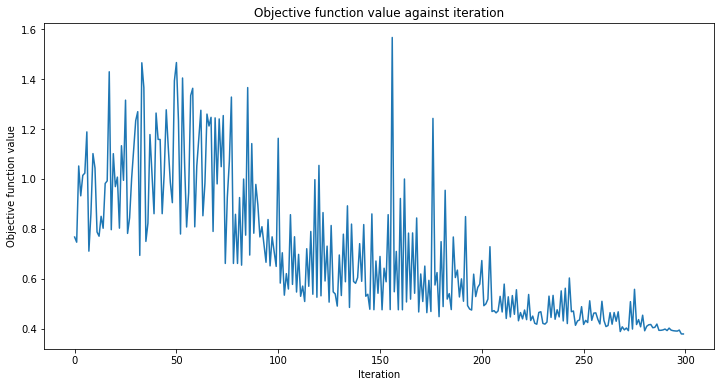

1.0

In [25]:



objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit classifier to data
estimator_classifier.fit(X_train_augDot[0:maxEvents], y_train_augDot[0:maxEvents])

# return to default figsize
# plt.rcParams["figure.figxsize"] = (6, 4)

# score classifier
estimator_classifier.score(X_test_augDot[0:maxEvents], y_test_augDot[0:maxEvents])

In [26]:
estimator_classifier.score(X_train_augDot[0:maxEvents], y_train_augDot[0:maxEvents])

1.0

In [27]:
estimator_classifier.score(X_test_augDot[0:maxEvents], y_test_augDot[0:maxEvents])

1.0